### Adrián Contreras, Jaime González, Ignacio Jiménez y Pablo Torre

# Intro

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network

colormap = plt.cm.tab20

def str_color(r,g,b,a):
    return "#" + format(int(r*255), f'0{2}x') + format(int(g*255), f'0{2}x') + format(int(b*255), f'0{2}x') + format(int(a*255), f'0{2}x')

def assign_colors(values):
    colors = [str_color(*colormap(v)) for v in values]
    return colors

def draw_communities(G, coms, ax=None):
    colors = assign_colors([coms[n] for n in G.nodes()])
    nx.draw(G, with_labels=False, ax=ax, node_color=colors)
    ax.set_title(f"Q:{nx.community.modularity(G, to_communities_list(coms)):.4f}")

def to_communities_list(coms):
    c_pos = {v:i for i,v in enumerate(set(coms.values()))}

    num_c = len(c_pos)
    com_list = [[] for _ in range(num_c)]

    for k,v in coms.items():
        com_list[c_pos[v]].append(k)

    return com_list

In [ ]:
# cargar grafo
graph = nx.read_graphml("amazon_graph.graphml")

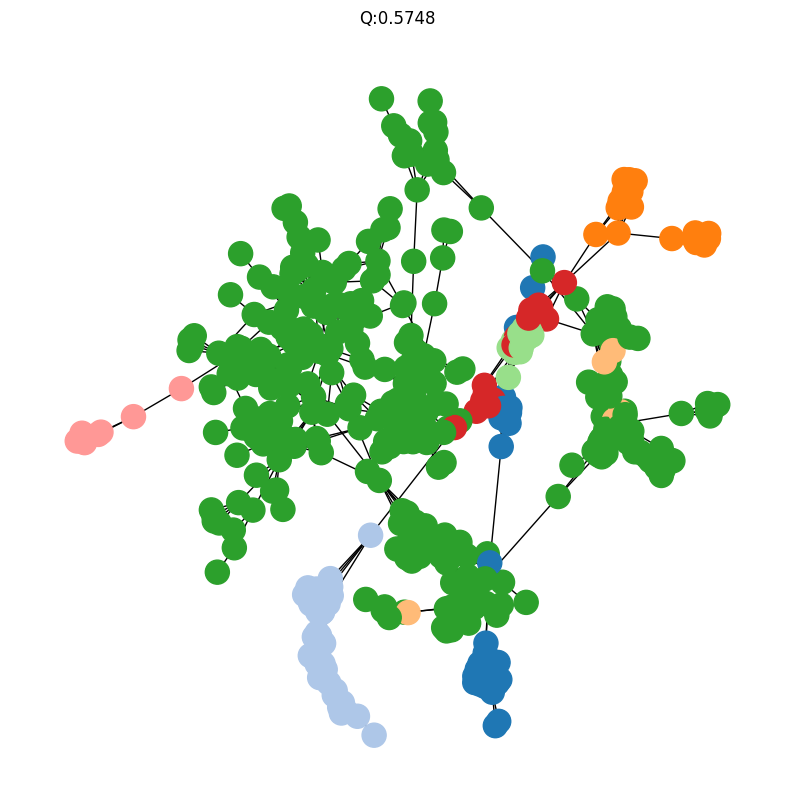

In [ ]:
# lo pintamos
_,ax = plt.subplots(1,figsize=(10,10))
coms = {n[0]: n[1]['community'] for n in graph.nodes.data()}
draw_communities(graph, coms, ax=ax)

# Ejercicio A – Estructura de comunidad con Leiden

defaultdict(<class 'list'>, {'176159': [0], '401449': [0], '321619': [0], '432229': [0], '59613': [0], '430314': [0], '30962': [0], '35067': [0], '217346': [0], '295177': [0], '190765': [0], '198973': [0], '141635': [0], '258382': [0], '108892': [0], '475666': [0], '326211': [0], '504412': [0], '539292': [0], '109222': [0], '51902': [0], '150207': [0], '428737': [0], '447224': [0], '500473': [0], '365309': [0], '365354': [0], '295752': [0], '265066': [0], '285549': [0], '127928': [0], '310236': [0], '373756': [0], '211967': [0], '336905': [0], '19509': [0], '199759': [0], '74895': [0], '484561': [0], '392463': [0], '279830': [0], '423198': [0], '197919': [0], '230788': [0], '236947': [0], '46508': [0], '380338': [0], '112056': [0], '404948': [0], '179698': [0], '187924': [0], '310851': [0], '470620': [0], '452208': [0], '122517': [0], '313006': [0], '108259': [0], '268123': [0], '317367': [0], '448649': [1], '172218': [1], '250046': [1], '497867': [1], '350442': [1], '14686': [1], '597

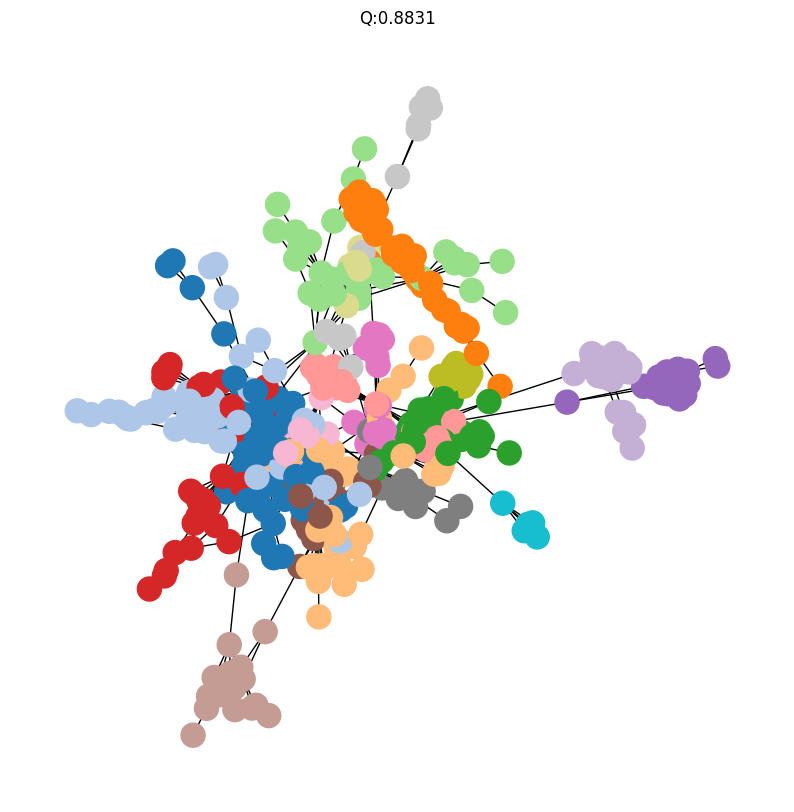

In [ ]:
from cdlib.algorithms import leiden


_,ax = plt.subplots(1,figsize=(10,10))
leiden_coms = leiden(graph).to_node_community_map()
print(leiden_coms)

coms = {k:v[0] for k,v in leiden(graph).to_node_community_map().items()}
# calculamos el numero de comunidades
num_c = len(set(coms.values()))
print(f"Numero de comunidades: {num_c}")
draw_communities(graph, coms,ax)

# Ejercicio B – Algoritmo Evolutivo multiobjetivo

### Funciones auxiliares

In [ ]:
# calculamos la estructura de comunidades para un individuo codificado con Locus

def get_communities(elem, graph):
    communities = {node: idx for idx, node in enumerate(graph.nodes())}

    changes = True

    while changes:
        changes = False

        for i, (node, community) in enumerate(communities.items()):
            neighbor_community = communities[elem[i]]
            new_community = min(community, neighbor_community)

            if new_community != community:
                changes = True

            communities[node] = new_community

    communities = list(communities.items())

    dic_communities = {}
    for node, community in communities:
        if community not in dic_communities:
            dic_communities[community] = []
        dic_communities[community].append(node)

    return dic_communities


In [ ]:
# lo mismo, pero otro formato de salida

def get_communities2(elem, graph):
    communities = {node: idx for idx, node in enumerate(graph.nodes())}

    changes = True

    while changes:
        changes = False

        for i, (node, community) in enumerate(communities.items()):
            neighbor_community = communities[elem[i]]
            new_community = min(community, neighbor_community)

            if new_community != community:
                changes = True

            communities[node] = new_community

    return communities

In [ ]:
# pintamos los frentes de pareto en distintos colores

def draw_fronts(fit_pop1, fit_pop2, fronts):
    # for i in range(len(fronts)):
    #     print(fit_pop1[i], fit_pop2[i], fronts[i])
    plt.scatter(fit_pop1, fit_pop2, c=fronts, cmap='gist_ncar')
    plt.xlabel('Fitness 1')
    plt.ylabel('Fitness 2')
    plt.title('Pareto Fronts')
    plt.show()

### Funciones de fitness

In [ ]:
def q_score (communities, graph=graph): # calcula el fitness con la formula de Q
    M = graph.number_of_edges()
    Q_score = 0
    for community in communities.keys():
        in_num_edges = 0
        out_num_edges = 0
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
                else:
                    out_num_edges += 1
        Q_score += in_num_edges/M - ((in_num_edges + out_num_edges)/(2*M))**2

    return Q_score


def num_internas (communities, graph=graph): # calcula el fitness como el numero de aristas internas
    in_num_edges = 0
    for community in communities.keys():
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
    return in_num_edges

def num_internas_div (communities, graph=graph): # calcula el fitness como el numero de aristas internas
    in_num_edges = 0
    for community in communities.keys():
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
    return in_num_edges/len(communities.keys())


def inverse_conductance (communities, graph=graph):
    inner = 0
    for community in communities.keys():
        in_num_edges = 0
        out_num_edges = 0
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
                else:
                    out_num_edges += 1
        inner += in_num_edges/(in_num_edges + 2*out_num_edges)

    return inner


def conductance (communities, graph=graph):
    conductance = 0
    for community in communities.keys():
        in_num_edges = 0
        out_num_edges = 0
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
                else:
                    out_num_edges += 1
        conductance += out_num_edges/(2*in_num_edges + out_num_edges)

    return conductance


def community_score (communities, graph=graph):
    community_sc = 0

    for community in communities.keys():
        in_num_edges = 0
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
        community_sc += (2*in_num_edges / len(communities[community]))**2

    return community_sc


def community_score_modified (communities, graph=graph):
    community_score = 0

    for community in communities.keys():
        in_num_edges = 0
        for node in communities[community]:
            for neighbor in graph.neighbors(node):
                if neighbor in communities[community]:
                    in_num_edges += 1
        community_score += (2*in_num_edges / len(communities[community]))**2

    return community_score/len(communities.keys())

### Funciones del algoritmo genético

In [ ]:
import random
import copy
from IPython.display import clear_output


MAXIMIZE = (True, True)


# inicializar población de forma aleatoria (codificación Locus)
def create (graph, N=100): # crea población
    pop = []
    for _ in range(N):
        e = []
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            e.append(random.choice(neighbors))
        pop.append(e)
    return pop


def fitness(pop, fit1, fit2):
    communities = [get_communities(ind, graph) for ind in pop]
    s1 = [fit1(c) for c in communities]
    s2 = [fit2(c) for c in communities]
    return (s1, s2)


def select (pop, fit_pop1, fit_pop2, T): # devuelve un individuo seleccionado por torneo
    rand = random.choices([0,1], weights=[0.7,0.3])[0]
    index_indvs = random.choices(range(len(pop)), k=T)
    if rand == 0:
        fit_random = fit_pop1
    else:
        fit_random = fit_pop2
    if MAXIMIZE[rand] == True:
        index_indv = index_indvs[np.argmax([fit_random[i] for i in index_indvs])]
    else:
        index_indv = index_indvs[np.argmin([fit_random[i] for i in index_indvs])]
    return copy.deepcopy(pop[index_indv])


def crossover (ind1, ind2, pcross):
    # devuelve una tupla con los dos hijos
    if pcross < random.random():
        return (ind1, ind2)

    mask = random.sample((0,1), k=len(ind1), counts=(len(ind1), len(ind1)))
    hijo1 = [None]*len(ind1)
    hijo2 = [None]*len(ind1)
    for i in range(len(ind1)):
        if mask[i] == 0:
            hijo1[i]=ind1[i]
            hijo2[i]=ind2[i]
        else:
            hijo1[i]=ind2[i]
            hijo2[i]=ind1[i]

    return (hijo1, hijo2)


def mutate (ind, pmut): # la mutación consistirá en intercambiar elementos
    # devuelve el individuo mutado
    for i, g in enumerate(graph.nodes()):
        if pmut > random.random():
            neighbors = list(graph.neighbors(g))
            ind[i] = random.choice(neighbors)
    return ind


def dominates (fit1_pop, fit2_pop, ind1, ind2, maximize=MAXIMIZE): # devuelve True si ind1 domina a ind2
    if maximize[0] and maximize[1]:
        return fit1_pop[ind1] > fit1_pop[ind2] and fit2_pop[ind1] >= fit2_pop[ind2] \
            or fit1_pop[ind1] >= fit1_pop[ind2] and fit2_pop[ind1] > fit2_pop[ind2]
    elif maximize[0] and not maximize[1]:
        return fit1_pop[ind1] > fit1_pop[ind2] and fit2_pop[ind1] <= fit2_pop[ind2] \
            or fit1_pop[ind1] >= fit1_pop[ind2] and fit2_pop[ind1] < fit2_pop[ind2]
    elif not maximize[0] and maximize[1]:
        return fit1_pop[ind1] < fit1_pop[ind2] and fit2_pop[ind1] >= fit2_pop[ind2] \
            or fit1_pop[ind1] <= fit1_pop[ind2] and fit2_pop[ind1] > fit2_pop[ind2]
    else:
        return fit1_pop[ind1] < fit1_pop[ind2] and fit2_pop[ind1] <= fit2_pop[ind2] \
            or fit1_pop[ind1] <= fit1_pop[ind2] and fit2_pop[ind1] < fit2_pop[ind2]


# devuelve una lista de frentes, cada frente es una lista de individuos
def calculate_fronts (fit1_pop, fit2_pop):
    front = [0]*len(fit1_pop)
    for i in range(len(fit1_pop)):
        for j in range(len(fit1_pop)):
            if dominates(fit1_pop, fit2_pop, i, j):
                front[j] += 1
    return front

# devuelve una lista de índices de soluciones ordenadas por distancia de crowding (del peor frente)
def calculate_crowding_distances (fit_pop1, fit_pop2, last_front_index):
    num_solutions = len(last_front_index)
    crowding_distances = [0] * len(fit_pop1)

    # Calcular la distancia de crowding para cada objetivo
    for obj_index in [fit_pop1, fit_pop2]:
        # Ordenar las soluciones en función del valor del objetivo actual
        sorted_indices = sorted(last_front_index, key=lambda x: obj_index[x])

        # Establecer las distancias de crowding para las soluciones extremas
        crowding_distances[sorted_indices[0]] = float('inf')
        crowding_distances[sorted_indices[-1]] = float('inf')

        # Calcular la distancia de crowding para las soluciones intermedias
        for i in range(1, num_solutions - 1):
            crowding_distances[sorted_indices[i]] += (
                (obj_index[sorted_indices[i + 1]] - obj_index[sorted_indices[i - 1]]) /
                (obj_index[sorted_indices[-1]] - obj_index[sorted_indices[0]] + 1e-7)
            )

    # Ordenar las soluciones en función de la distancia de crowding
    sorted_indices = sorted(last_front_index, key=lambda x: crowding_distances[x], reverse=True)
    return sorted_indices


# algoritmo NSGA-II
def evolve (pop, fit1, fit2, pmut, pcross=0.7, ngen=100, T=2, trace=1):
    track_fitness1 = []
    track_fitness2 = []

    # calcular fitness
    fit_pop1, fit_pop2 = fitness(pop, fit1, fit2)

    # bucle principal
    t = 0
    while t < ngen:
        # inicializar población de descendientes
        offspring = []
        # generar descendientes
        for _ in range(len(pop)//2): # No pop, sorted_pop?
            # seleccionar padres
            p1 = select(pop, fit_pop1, fit_pop2, T)
            p2 = select(pop, fit_pop1, fit_pop2, T)
            # cruzar padres
            h1, h2 = crossover(p1, p2, pcross)
            # mutar descendientes
            h1 = mutate(h1, pmut)
            h2 = mutate(h2, pmut)
            # añadir descendientes a la población
            offspring.append(h1)
            offspring.append(h2)

        # unir población padre y población descendiente
        pop = pop + offspring
        # ordenar población conjunta
        fit_pop1, fit_pop2 = fitness(pop, fit1, fit2)

        # calcular frentes
        fronts = calculate_fronts(fit_pop1, fit_pop2)

        new_pop = []
        new_pop_indx = []
        breaking_point = 0
        # seleccionar población superviviente
        for i in range(np.max(fronts) + 1):
            num_elements = np.sum(np.array(fronts) == i)
            if len(new_pop) + num_elements >= len(pop)//2:
                breaking_point = i
                break
            for j in range(len(fronts)):
                if fronts[j] == i:
                    new_pop.append(pop[j])
                    new_pop_indx.append(j)

        # añadir soluciones del peor frente (si aún no se ha alcanzado el tamaño de la población)
        if len(new_pop) < len(pop)//2:
            last_front_index = np.where(np.array(fronts) == breaking_point)[0]
            last_front_index_crowd = calculate_crowding_distances(fit_pop1, fit_pop2, last_front_index)
            ln = len(new_pop)
            new_pop += [pop[i] for i in last_front_index_crowd[:len(pop)//2 - len(new_pop)]]
            new_pop_indx += [i for i in last_front_index_crowd[:len(pop)//2 - ln]]

        pop = new_pop

        # incrementar número de generación
        t += 1

        # mostrar resultados cada "trace" generaciones
        if t % trace == 0:
            clear_output()
            print("Generación: ", t)
            print("New_pop de los padres: ", len(np.where(np.array(new_pop_indx) < len(pop))[0]))
            print("New_pop de los hijos: ", len(np.where(np.array(new_pop_indx) >= len(pop))[0]))
            print("Población: ", len(pop))
            if MAXIMIZE[0]:
                print("Fitness 1: ", np.max(fit_pop1))
                track_fitness1.append(np.max(fit_pop1))
            else:
                print("Fitness 1: ", np.min(fit_pop1))
                track_fitness1.append(np.min(fit_pop1))
            if MAXIMIZE[1]:
                print("Fitness 2: ", np.max(fit_pop2))
                track_fitness2.append(np.max(fit_pop2))
            else:
                print("Fitness 2: ", np.min(fit_pop2))
                track_fitness2.append(np.min(fit_pop2))
            draw_fronts(fit_pop1, fit_pop2, fronts)
            plt.plot(track_fitness1)
            plt.show()
            plt.plot(track_fitness2)
            plt.show()
    # devolver población final
    return pop

# Pruebas varias

### 40 con max num internas y community scores

In [ ]:
pop = create(graph, N=40)
len(pop[0])

475

Generación:  620
New_pop de los padres:  27
New_pop de los hijos:  13
Población:  40
Fitness 1:  2248
Fitness 2:  3344.043440062855


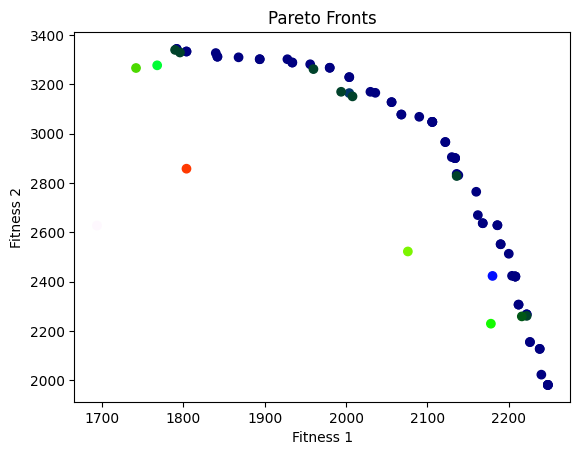

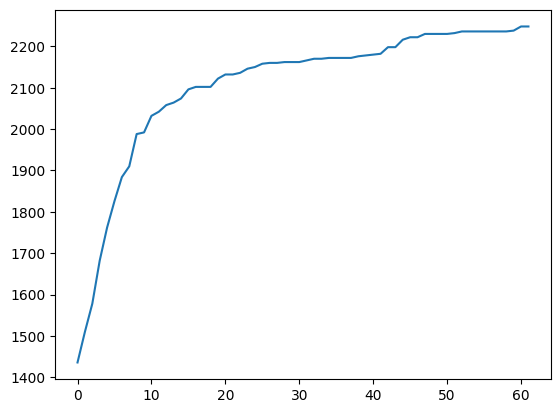

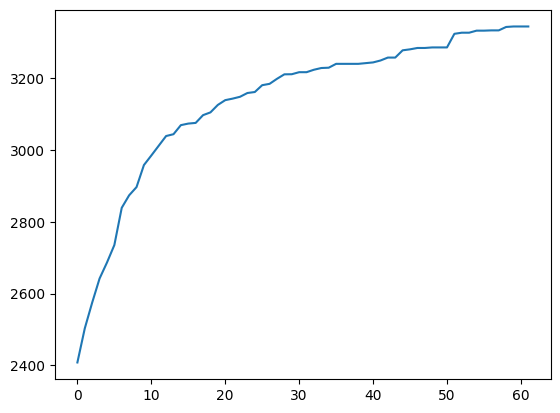

In [ ]:
MAXIMIZE = (True, True)
final_pop = evolve(pop, num_internas, community_score, pmut=2/475, pcross=0.2, ngen=625, T=4, trace=10)

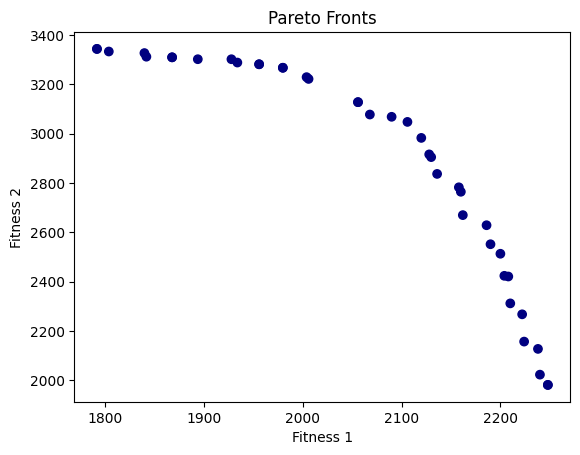

Num. soluciones en el frente de Pareto:  40
Num. communities:  95 Fitness 1:  1792 Fitness 2:  3344.043440062855
Num. communities:  26 Fitness 1:  2248 Fitness 2:  1980.736344094008
Num. communities:  95 Fitness 1:  1792 Fitness 2:  3344.043440062855
Num. communities:  26 Fitness 1:  2248 Fitness 2:  1980.736344094008
Num. communities:  68 Fitness 1:  2006 Fitness 2:  3222.2991542525224
Num. communities:  51 Fitness 1:  2136 Fitness 2:  2836.905487025142
Num. communities:  60 Fitness 1:  2056 Fitness 2:  3128.071195827173
Num. communities:  44 Fitness 1:  2120 Fitness 2:  2983.000137410904
Num. communities:  31 Fitness 1:  2222 Fitness 2:  2267.2190958062315
Num. communities:  82 Fitness 1:  1894 Fitness 2:  3302.3076836757064
Num. communities:  27 Fitness 1:  2238 Fitness 2:  2126.908392864542
Num. communities:  28 Fitness 1:  2240 Fitness 2:  2022.4162560444493
Num. communities:  51 Fitness 1:  2106 Fitness 2:  3047.9131465770643
Num. communities:  47 Fitness 1:  2162 Fitness 2:  266

In [ ]:
fit1_pop, fit2_pop = fitness(final_pop, num_internas, community_score)
fronts = calculate_fronts(fit1_pop, fit2_pop)

min_value = 475

draw_fronts(fit1_pop, fit2_pop, fronts)

# nos quedamos con el primer frente
last_front_index = np.where(np.array(fronts) == 0)[0]
print("Num. soluciones en el frente de Pareto: ", len(last_front_index))

for i in last_front_index:
    communities = get_communities(final_pop[i], graph)
    if len(communities) < min_value:
        min_value = len(communities)
        comunities2 = get_communities2(final_pop[i], graph)
    print("Num. communities: ", len(communities), "Fitness 1: ", num_internas(communities), "Fitness 2: ", community_score(communities))

print(min_value)

### Con num_internas_div y community score

In [ ]:
pop = create(graph, N=40)
len(pop[0])

475

Generación:  620
New_pop de los padres:  31
New_pop de los hijos:  9
Población:  40
Fitness 1:  85.46153846153847
Fitness 2:  3324.383040431857


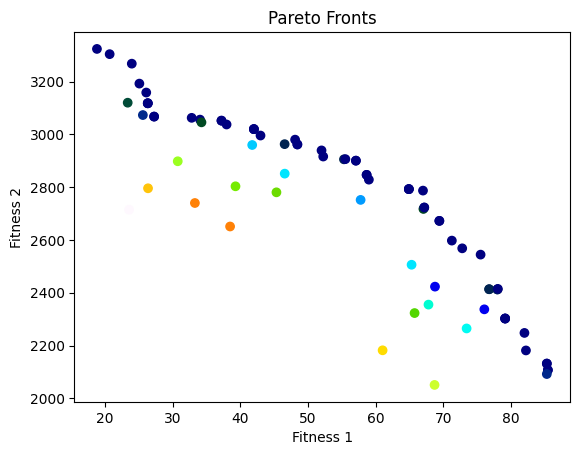

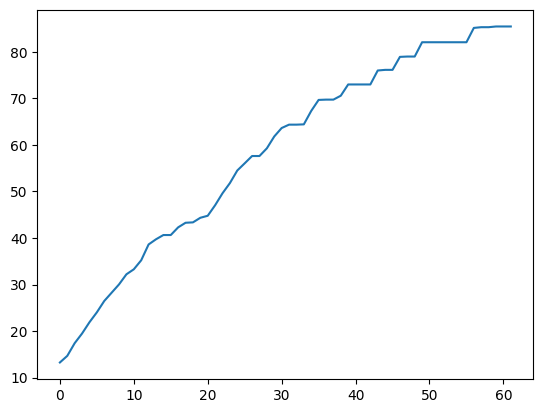

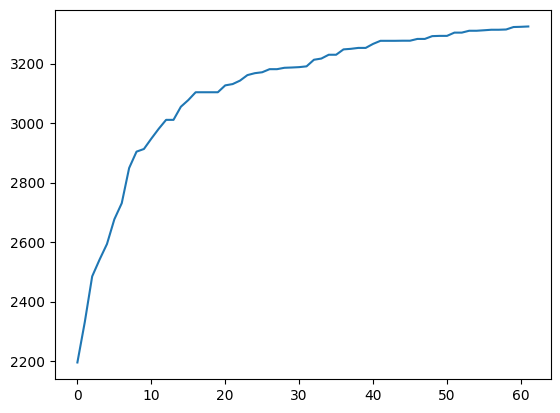

In [ ]:
MAXIMIZE = (True, True)
final_pop = evolve(pop, num_internas_div, community_score, pmut=2/475, pcross=0.2, ngen=625, T=4, trace=10)

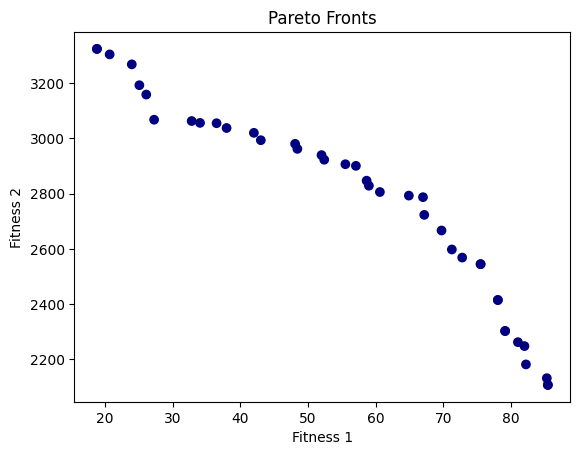

Num. soluciones en el frente de Pareto:  40
Num. communities:  26 Fitness 1:  85.46153846153847 Fitness 2:  2106.9802440541134
Num. communities:  93 Fitness 1:  18.795698924731184 Fitness 2:  3324.383040431857
Num. communities:  93 Fitness 1:  18.795698924731184 Fitness 2:  3324.383040431857
Num. communities:  26 Fitness 1:  85.46153846153847 Fitness 2:  2106.9802440541134
Num. communities:  69 Fitness 1:  27.246376811594203 Fitness 2:  3067.8721292107507
Num. communities:  76 Fitness 1:  23.94736842105263 Fitness 2:  3268.4759575066423
Num. communities:  29 Fitness 1:  75.51724137931035 Fitness 2:  2544.569744672201
Num. communities:  27 Fitness 1:  82.22222222222223 Fitness 2:  2181.339903193658
Num. communities:  28 Fitness 1:  78.07142857142857 Fitness 2:  2414.5938171523267
Num. communities:  47 Fitness 1:  43.02127659574468 Fitness 2:  2993.637672616435
Num. communities:  86 Fitness 1:  20.674418604651162 Fitness 2:  3304.5554889231976
Num. communities:  28 Fitness 1:  78.0714285

In [ ]:
fit1_pop, fit2_pop = fitness(final_pop, num_internas_div, community_score)
fronts = calculate_fronts(fit1_pop, fit2_pop)

min_value = 475

draw_fronts(fit1_pop, fit2_pop, fronts)

# nos quedamos con el primer frente
last_front_index = np.where(np.array(fronts) == 0)[0]
print("Num. soluciones en el frente de Pareto: ", len(last_front_index))

for i in last_front_index:
    communities = get_communities(final_pop[i], graph)

    if len(communities) < min_value:
        min_value = len(communities)
        comunities2 = get_communities2(final_pop[i], graph)
    print("Num. communities: ", len(communities), "Fitness 1: ", num_internas_div(communities), "Fitness 2: ", community_score(communities))

print(min_value)

### Con Q-score y community score

In [ ]:
pop = create(graph, N=100)
len(pop[0])

475

Generación:  250
New_pop de los padres:  70
New_pop de los hijos:  30
Población:  100
Fitness 1:  1.7666375861714756
Fitness 2:  3279.109247727767


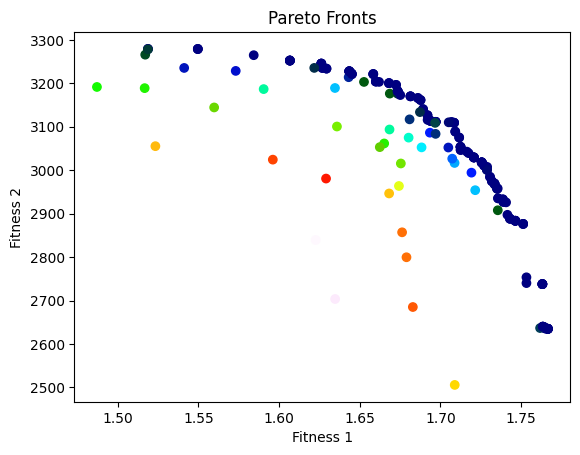

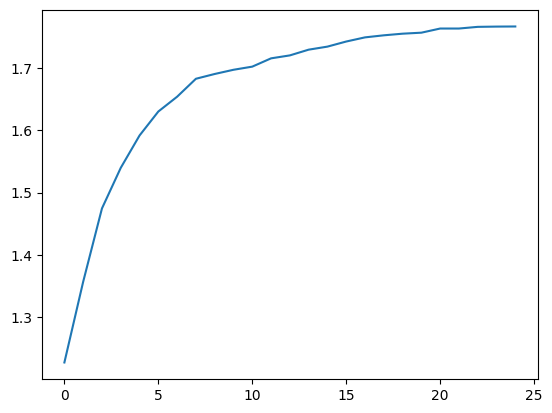

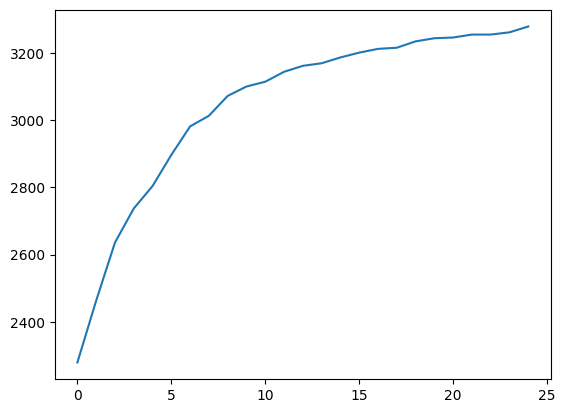

In [ ]:
MAXIMIZE = (True, True)
final_pop = evolve(pop, q_score, community_score, pmut=2/475, pcross=0.2, ngen=250, T=4, trace=10)

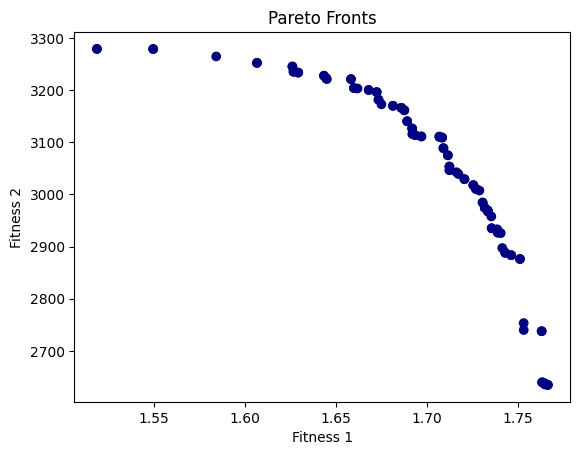

Num. soluciones en el frente de Pareto:  100
Num. communities:  83 Fitness 1:  1.518694145475713 Fitness 2:  3279.109247727767
Num. communities:  42 Fitness 1:  1.7666375861714756 Fitness 2:  2634.8069946971495
Num. communities:  83 Fitness 1:  1.518694145475713 Fitness 2:  3279.109247727767
Num. communities:  42 Fitness 1:  1.7666375861714756 Fitness 2:  2634.8069946971495
Num. communities:  70 Fitness 1:  1.5842679276616152 Fitness 2:  3264.674362035939
Num. communities:  45 Fitness 1:  1.7533573348475169 Fitness 2:  2753.4080843409715
Num. communities:  43 Fitness 1:  1.7513093356236307 Fitness 2:  2876.2725550945047
Num. communities:  42 Fitness 1:  1.7632349542321042 Fitness 2:  2737.792220348316
Num. communities:  43 Fitness 1:  1.7635074501232653 Fitness 2:  2639.7224349091643
Num. communities:  74 Fitness 1:  1.549606378971878 Fitness 2:  3278.923240518215
Num. communities:  74 Fitness 1:  1.549606378971878 Fitness 2:  3278.923240518215
Num. communities:  69 Fitness 1:  1.60669

In [ ]:
fit1_pop, fit2_pop = fitness(final_pop, q_score, community_score)
fronts = calculate_fronts(fit1_pop, fit2_pop)

min_value = 475

draw_fronts(fit1_pop, fit2_pop, fronts)

# nos quedamos con el primer frente
last_front_index = np.where(np.array(fronts) == 0)[0]
print("Num. soluciones en el frente de Pareto: ", len(last_front_index))

for i in last_front_index:
    communities = get_communities(final_pop[i], graph)

    if len(communities) < min_value:
        min_value = len(communities)
        comunities2 = get_communities2(final_pop[i], graph)
    print("Num. communities: ", len(communities), "Fitness 1: ", q_score(communities), "Fitness 2: ", community_score(communities))


Número de comunidades mínimo:  42


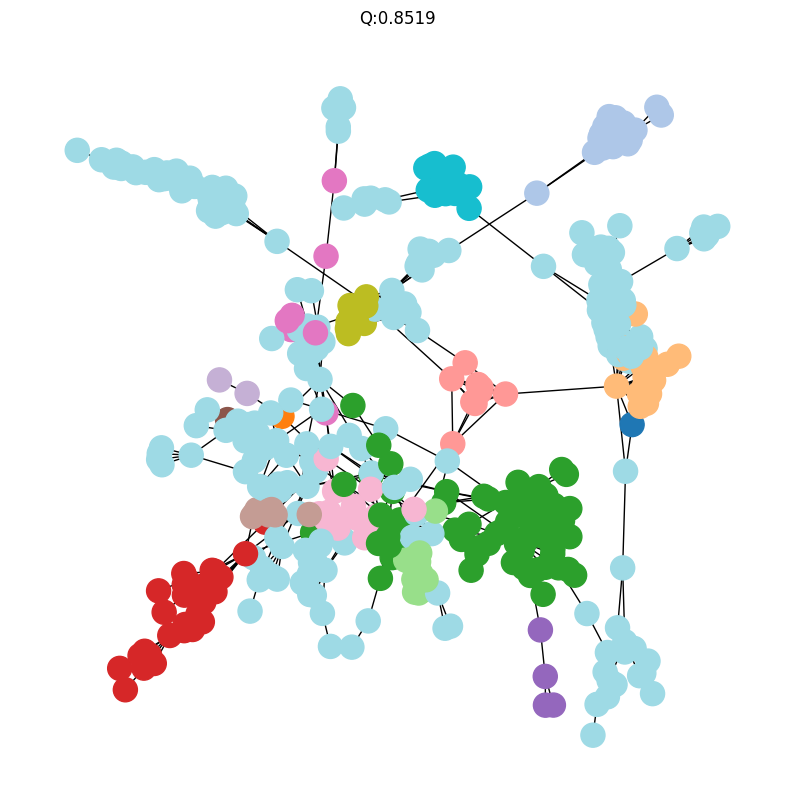

In [ ]:
print("Número de comunidades mínimo: ", min_value)

_,ax = plt.subplots(1,figsize=(10,10))
coms = {n:comunities2[n] for n in comunities2.keys()}

draw_communities(graph, coms, ax=ax)



### Con Q-score y conductance

In [ ]:
pop = create(graph, N=100)
len(pop[0])

475

Generación:  250
New_pop de los padres:  97
New_pop de los hijos:  3
Población:  100
Fitness 1:  1.7589488506665447
Fitness 2:  5.4752098901575135


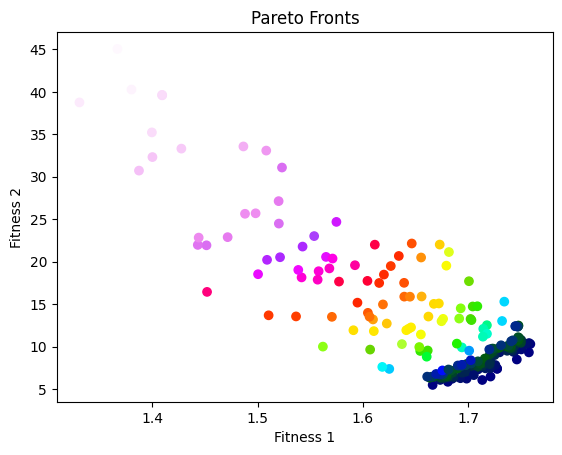

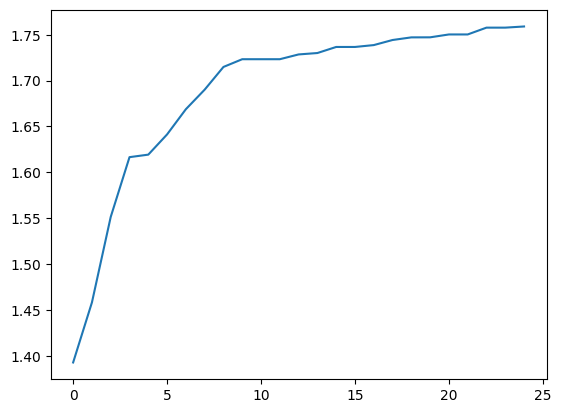

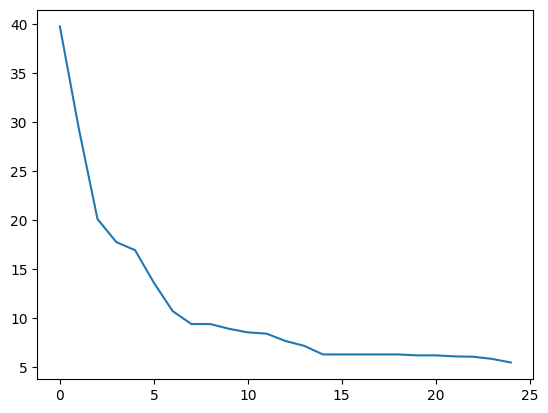

In [ ]:
MAXIMIZE = (True, False)
final_pop = evolve(pop, q_score, conductance, pmut=0.05, pcross=0.2, ngen=250, T=6, trace=10)

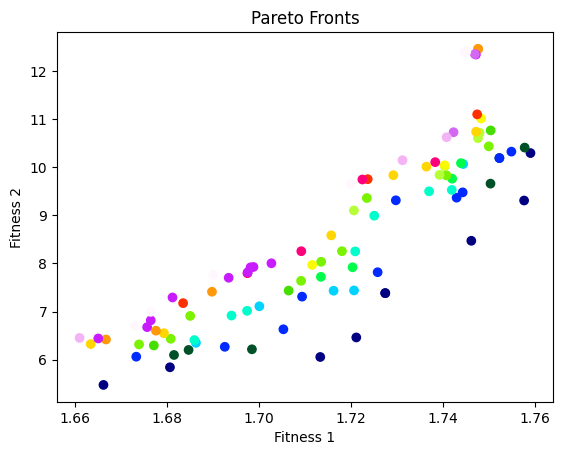

Num. soluciones en el frente de Pareto:  9
Num. communities:  36 Fitness 1:  1.7210936786659978 Fitness 2:  6.4620077845132595
Num. communities:  36 Fitness 1:  1.7273835543736307 Fitness 2:  7.38295629492063
Num. communities:  36 Fitness 1:  1.7273835543736307 Fitness 2:  7.38295629492063
Num. communities:  35 Fitness 1:  1.6805987918873266 Fitness 2:  5.842064043410947
Num. communities:  42 Fitness 1:  1.7589488506665447 Fitness 2:  10.2937411219274
Num. communities:  41 Fitness 1:  1.7460894699598244 Fitness 2:  8.470706814154742
Num. communities:  35 Fitness 1:  1.7132594217951063 Fitness 2:  6.0558023463260735
Num. communities:  37 Fitness 1:  1.666150446265523 Fitness 2:  5.4752098901575135
Num. communities:  40 Fitness 1:  1.7575646143398465 Fitness 2:  9.307707285661266


In [ ]:
fit1_pop, fit2_pop = fitness(final_pop, q_score, conductance)
fronts = calculate_fronts(fit1_pop, fit2_pop)

min_value = 475

draw_fronts(fit1_pop, fit2_pop, fronts)

# nos quedamos con el primer frente
last_front_index = np.where(np.array(fronts) == 0)[0]
print("Num. soluciones en el frente de Pareto: ", len(last_front_index))

for i in last_front_index:
    communities = get_communities(final_pop[i], graph)

    if len(communities) < min_value:
        min_value = len(communities)
        comunities2 = get_communities2(final_pop[i], graph)
    print("Num. communities: ", len(communities), "Fitness 1: ", q_score(communities), "Fitness 2: ", conductance(communities))

Número de comunidades mínimo:  35


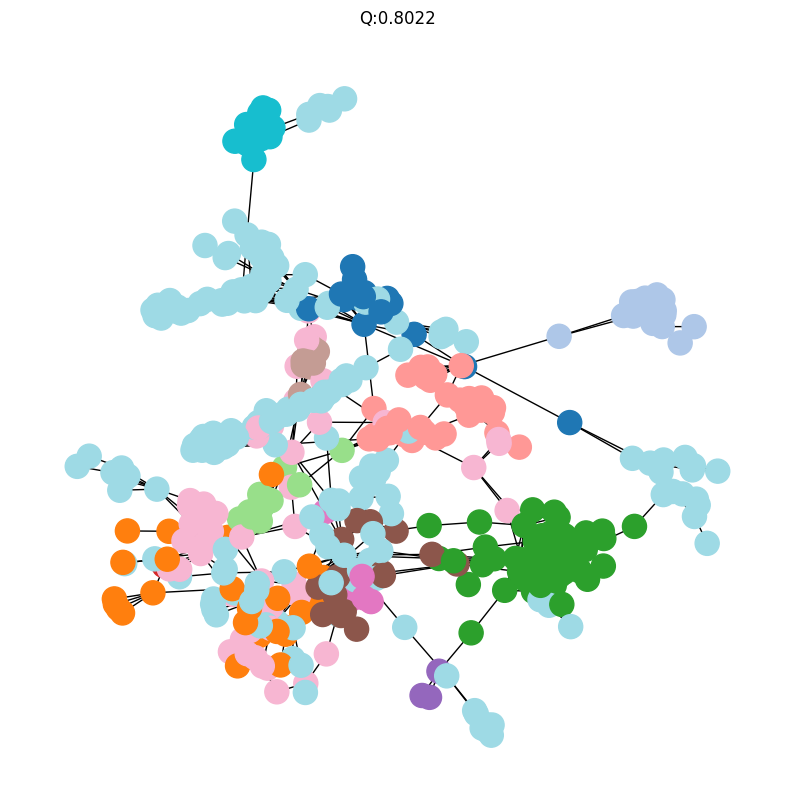

In [ ]:
print("Número de comunidades mínimo: ", min_value)

_,ax = plt.subplots(1,figsize=(10,10))
coms = {n:comunities2[n] for n in comunities2.keys()}

draw_communities(graph, coms, ax=ax)


# Mejor Solución

In [ ]:
pop = create(graph, N=40)
len(pop[0])

475

Generación:  620
New_pop de los padres:  35
New_pop de los hijos:  5
Población:  40
Fitness 1:  2348
Fitness 2:  137.81380539659017


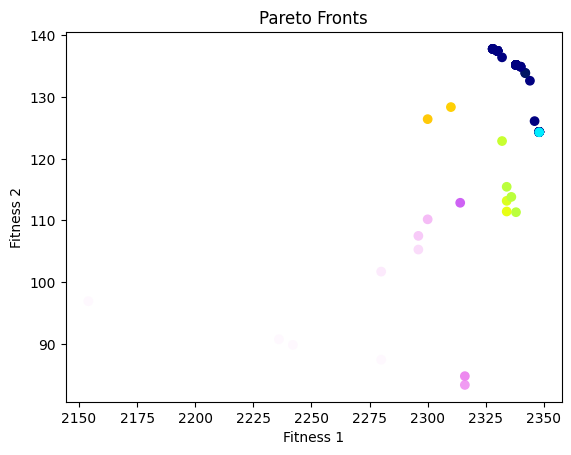

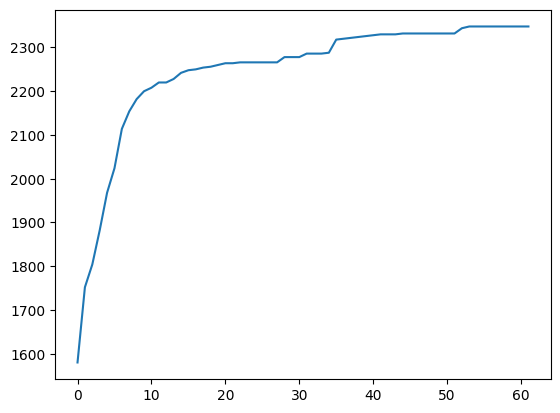

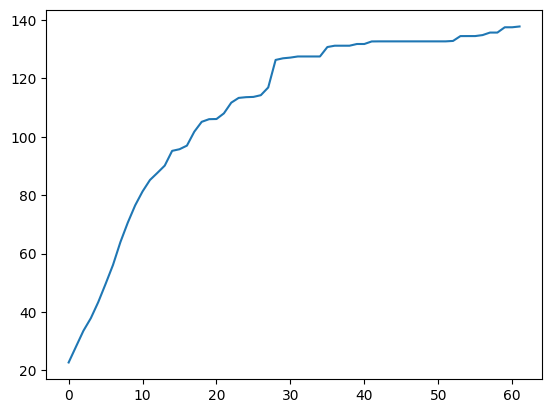

In [ ]:
MAXIMIZE = (True, True)
final_pop = evolve(pop, num_internas, community_score_modified, pmut=2/475, pcross=0.2, ngen=625, T=4, trace=10)

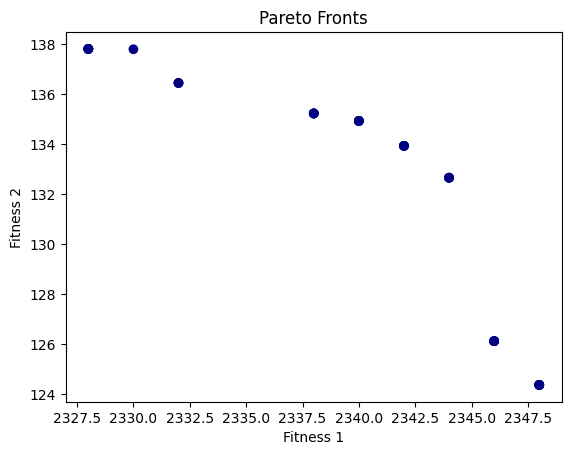

Num. soluciones en el frente de Pareto:  40
Num. communities:  8 Fitness 1:  2348 Fitness 2:  124.35651043720515
Num. communities:  10 Fitness 1:  2328 Fitness 2:  137.81380539659017
Num. communities:  8 Fitness 1:  2348 Fitness 2:  124.35651043720515
Num. communities:  10 Fitness 1:  2328 Fitness 2:  137.81380539659017
Num. communities:  9 Fitness 1:  2344 Fitness 2:  132.6548756476879
Num. communities:  9 Fitness 1:  2346 Fitness 2:  126.11047109164906
Num. communities:  9 Fitness 1:  2332 Fitness 2:  136.44914639963523
Num. communities:  10 Fitness 1:  2338 Fitness 2:  135.2296699172528
Num. communities:  9 Fitness 1:  2330 Fitness 2:  137.80056300973047
Num. communities:  9 Fitness 1:  2346 Fitness 2:  126.11047109164906
Num. communities:  9 Fitness 1:  2342 Fitness 2:  133.932721525091
Num. communities:  9 Fitness 1:  2344 Fitness 2:  132.6548756476879
Num. communities:  9 Fitness 1:  2332 Fitness 2:  136.44914639963523
Num. communities:  10 Fitness 1:  2338 Fitness 2:  135.229669

In [ ]:
fit1_pop, fit2_pop = fitness(final_pop, num_internas, community_score_modified)
fronts = calculate_fronts(fit1_pop, fit2_pop)

min_value = 475

draw_fronts(fit1_pop, fit2_pop, fronts)

# nos quedamos con el primer frente
last_front_index = np.where(np.array(fronts) == 0)[0]
print("Num. soluciones en el frente de Pareto: ", len(last_front_index))

for i in last_front_index:
    communities = get_communities(final_pop[i], graph)
    if len(communities) < min_value:
        min_value = len(communities)
        comunities2 = get_communities2(final_pop[i], graph)
    print("Num. communities: ", len(communities), "Fitness 1: ", num_internas(communities), "Fitness 2: ", community_score_modified(communities))

print(min_value)

Número de comunidades mínimo:  8


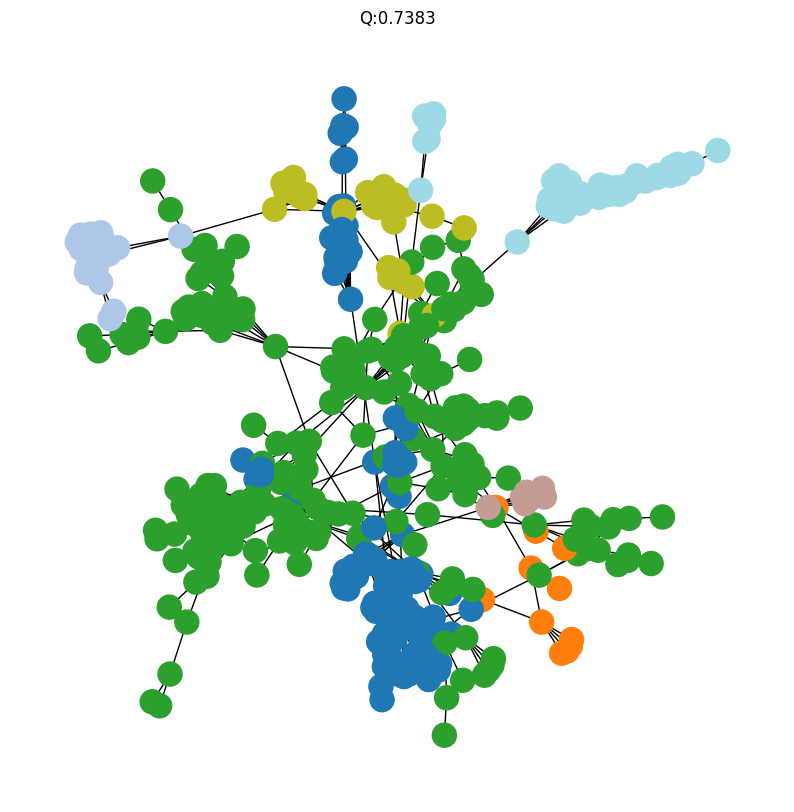

In [ ]:
print("Número de comunidades mínimo: ", min_value)

_,ax = plt.subplots(1,figsize=(10,10))
coms = {n:comunities2[n] for n in comunities2.keys()}

draw_communities(graph, coms, ax=ax)